*Flow Capacity Variable, DBSCAN*

In [31]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt

import glob
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np
import xarray as xr

calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Aggregate source capacities from all SPORE NetCDF files into a single DataFrame, with each row representing a SPORE and columns representing technology capacities.

In [32]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc') # Assuming SPORE files are stored in 'results/spores/' directory

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_source = data['flow_cap'].to_dataframe().reset_index()
    
    # Filter out any "_to_" techs and drop NaN values in flow_cap
    data_source = data_source[~data_source['techs'].str.contains(r'_to_', regex=True)]
    data_source = data_source.dropna(subset=['flow_cap'])
                                   
    # Aggregate the source capacities by tech
    aggregated_flow_cap = data_source.groupby('techs')['flow_cap'].sum().reset_index()
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_flow_cap.set_index('techs')['flow_cap']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_flow_cap['techs']
aggregated_matrix = aggregated_matrix.drop(columns=['lost_load'])
aggregated_all = aggregated_matrix.copy()
aggregated_matrix = aggregated_matrix.drop(columns=['import_power','export_power','demand_power','curtailment'])

# Show the resulting matrix
aggregated_matrix

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,nuclear,solar_pv,wind_offshore,wind_onshore
spore_5,0.021306,3998.989336,3675.952809,1263.934835,0.002485,485.076166,24359.004328,4756.987354,6956.888585
minons_spore_8,1.668140,5549.403476,1378.567905,2068.114857,0.167569,493.506789,24359.003173,4756.645760,6953.000001
minoff_spore_7,0.442854,4057.682306,4363.532005,1083.344938,0.045860,487.120474,24359.000491,4748.000922,6953.457081
maxpv_spore_3,0.003669,5411.830325,4289.607355,0.031734,0.000359,485.010454,41873.275417,4756.999069,6953.000081
maxbat_spore_3,211.449166,8960.788041,902.070283,0.008979,0.000106,485.003073,24359.000073,4756.998508,6953.000025
...,...,...,...,...,...,...,...,...,...
minpv_spore_4,4.783517,4971.355842,3124.248330,1178.944061,0.437834,507.644718,24359.000001,4757.152753,6954.577481
maxoff_spore_5,0.007640,6029.604812,2662.138660,0.056897,0.000637,485.020681,24359.001065,12423.648215,6953.000423
minbat_spore_1,0.000062,8215.482213,2638.025995,381.163716,5.734455,614.514479,24359.000286,4756.674389,6957.151391
maxbio_spore_10,16.806411,12000.000000,337.165500,83.532898,1.993511,522.006372,24359.000170,4754.232221,6953.307272


Standardize the aggregated technology capacity data using `StandardScaler` to prepare for clustering.

In [33]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies

Compute and plot the distances to the 5th nearest neighbor for each SPORE configuration to help tune DBSCAN clustering parameters.

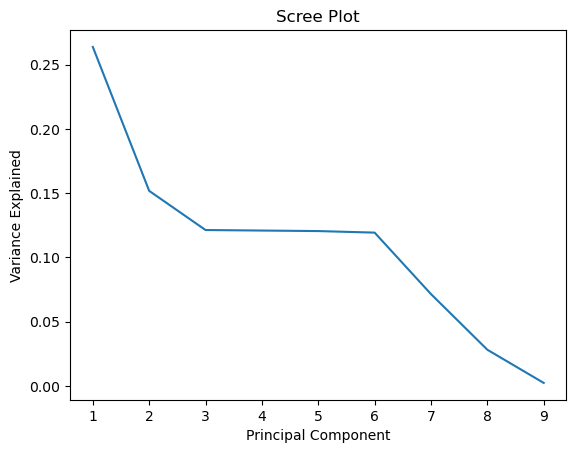

In [34]:
pca = PCA(n_components=9)
#fit PCA model to data
pca_fit = pca.fit(matrix_scaled)
# plot the scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_)
plt.title( 'Scree Plot') 
plt.xlabel( 'Principal Component')
plt.ylabel( 'Variance Explained')
plt.show()

In [35]:
# Reduce dimensionality
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

pca = PCA(n_components=6)
X_pca = pca.fit_transform(matrix_scaled)

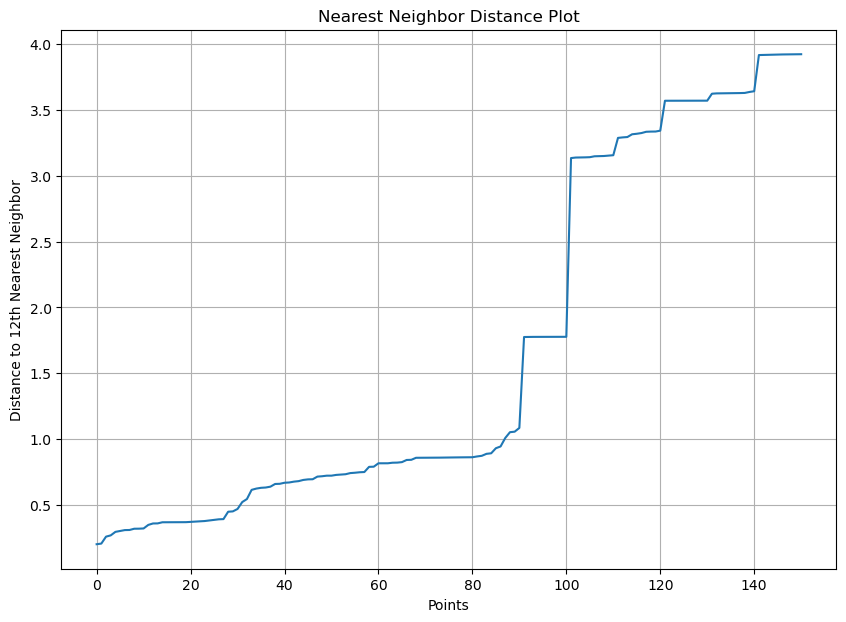

In [36]:
from sklearn.neighbors import NearestNeighbors

# Calculate the nearest neighbor distances
n_neighbors = 12 # You can adjust this value based on your analysis needs
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Sort the distances in ascending order
distances = np.sort(distances[:,n_neighbors-1], axis=0)

# Plot the distances
plt.figure(figsize=(10, 7))
plt.plot(distances)
plt.title('Nearest Neighbor Distance Plot')
plt.xlabel('Points')
plt.grid(True)
plt.ylabel('Distance to 12th Nearest Neighbor')
plt.show()

Run DBSCAN clustering with specified parameters and add the resulting cluster labels to the aggregated matrix.

In [37]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# eps: The maximum distance between two points for them to be considered as part of the same neighborhood. 
# min_samples: The number of points required to form a dense region (a cluster).
dbscan = DBSCAN(eps=0.8, min_samples= 12)

cluster_labels = dbscan.fit_predict(X_pca)

# Add the DBSCAN cluster labels to the aggregated_matrix
aggregated_matrix['Cluster_DBSCAN'] = cluster_labels
aggregated_all['Cluster_DBSCAN'] = cluster_labels
aggregated_all = aggregated_all[aggregated_all['Cluster_DBSCAN'] != -1]  # Remove noise points

aggregated_matrix

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,nuclear,solar_pv,wind_offshore,wind_onshore,Cluster_DBSCAN
spore_5,0.021306,3998.989336,3675.952809,1263.934835,0.002485,485.076166,24359.004328,4756.987354,6956.888585,0
minons_spore_8,1.668140,5549.403476,1378.567905,2068.114857,0.167569,493.506789,24359.003173,4756.645760,6953.000001,0
minoff_spore_7,0.442854,4057.682306,4363.532005,1083.344938,0.045860,487.120474,24359.000491,4748.000922,6953.457081,0
maxpv_spore_3,0.003669,5411.830325,4289.607355,0.031734,0.000359,485.010454,41873.275417,4756.999069,6953.000081,-1
maxbat_spore_3,211.449166,8960.788041,902.070283,0.008979,0.000106,485.003073,24359.000073,4756.998508,6953.000025,-1
...,...,...,...,...,...,...,...,...,...,...
minpv_spore_4,4.783517,4971.355842,3124.248330,1178.944061,0.437834,507.644718,24359.000001,4757.152753,6954.577481,0
maxoff_spore_5,0.007640,6029.604812,2662.138660,0.056897,0.000637,485.020681,24359.001065,12423.648215,6953.000423,-1
minbat_spore_1,0.000062,8215.482213,2638.025995,381.163716,5.734455,614.514479,24359.000286,4756.674389,6957.151391,2
maxbio_spore_10,16.806411,12000.000000,337.165500,83.532898,1.993511,522.006372,24359.000170,4754.232221,6953.307272,2


Display the number of SPORE configurations in each DBSCAN cluster.

In [38]:
# Check the number of points in each cluster
print(aggregated_matrix['Cluster_DBSCAN'].value_counts())

Cluster_DBSCAN
-1    70
 0    42
 2    22
 1    17
Name: count, dtype: int64


[2025-06-15 15:02:53] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_2300/1898625805.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



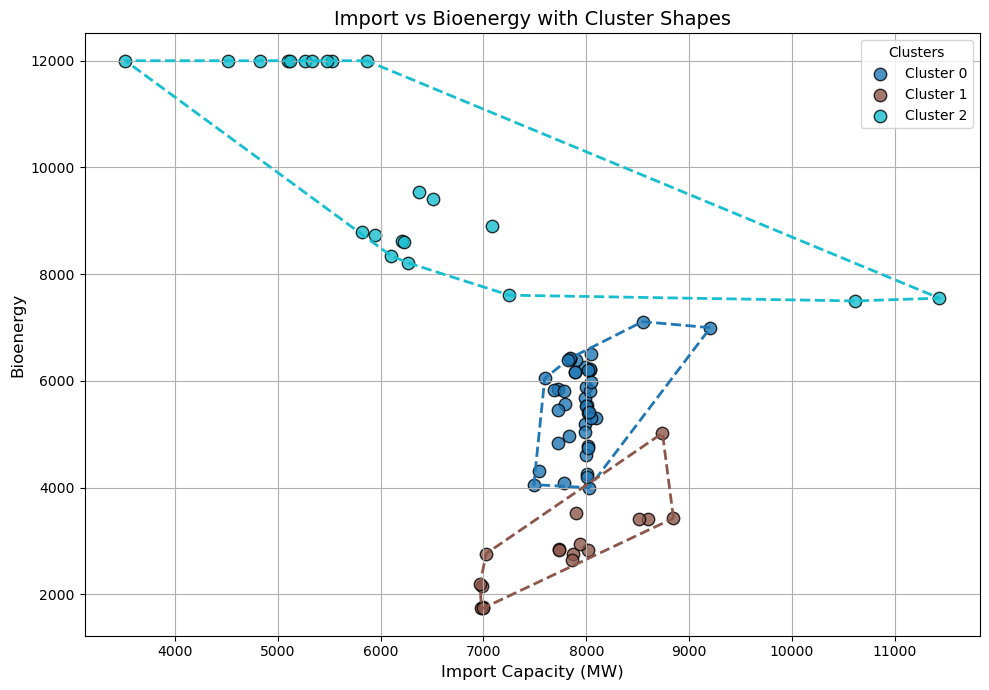

In [49]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['import_power'].values
y = aggregated_all['bioenergy'].values
cluster_label = aggregated_all['Cluster_DBSCAN'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_label)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_label == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Import Capacity (MW)', fontsize=12)
plt.ylabel('Bioenergy', fontsize=12)
plt.title('Import vs Bioenergy with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

[2025-06-15 15:02:53] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_2300/1875101714.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



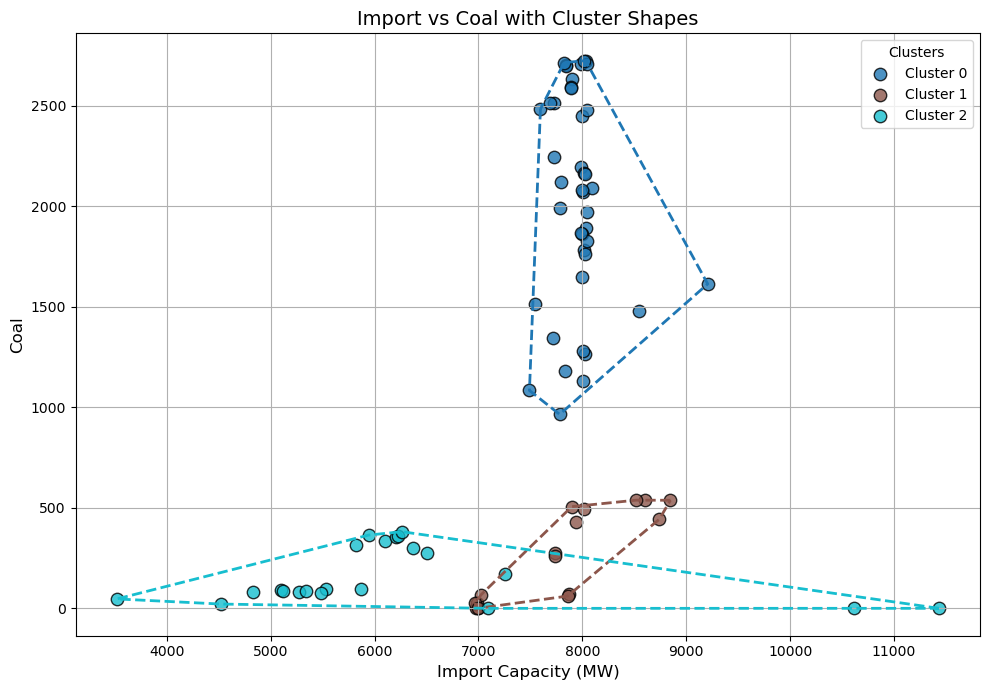

In [50]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['import_power'].values
y = aggregated_all['coal'].values
cluster_label = aggregated_all['Cluster_DBSCAN'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_label)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_label == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Import Capacity (MW)', fontsize=12)
plt.ylabel('Coal', fontsize=12)
plt.title('Import vs Coal with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

[2025-06-15 15:02:53] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_2300/3372690687.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



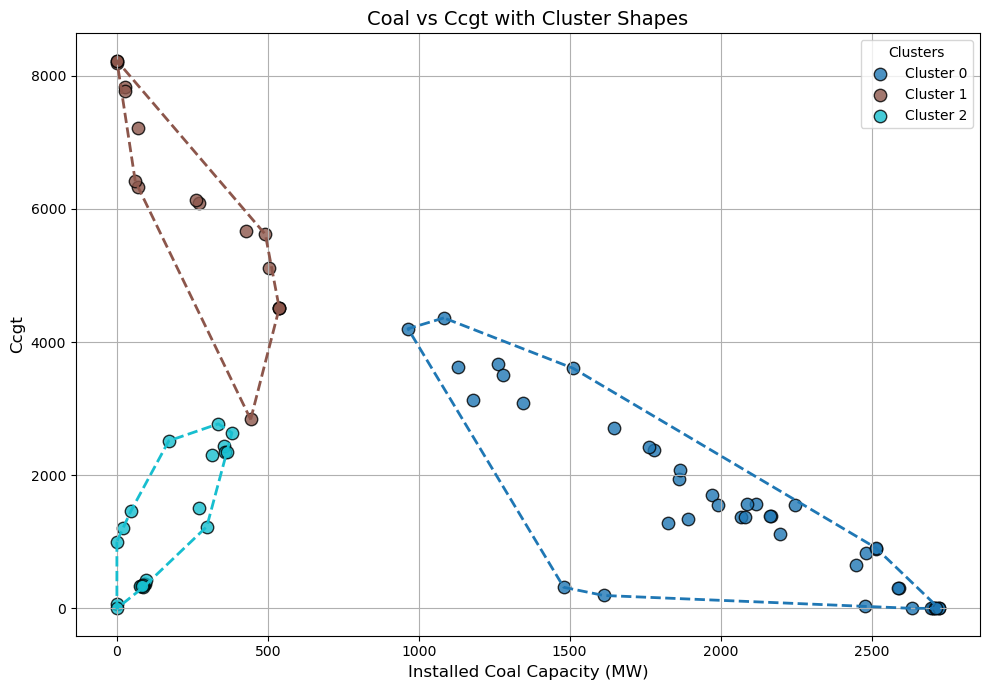

In [51]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['coal'].values
y = aggregated_all['ccgt'].values
cluster_label = aggregated_all['Cluster_DBSCAN'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_label)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_label == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Coal Capacity (MW)', fontsize=12)
plt.ylabel('Ccgt', fontsize=12)
plt.title('Coal vs Ccgt with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

[2025-06-15 15:02:53] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_2300/3265125636.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



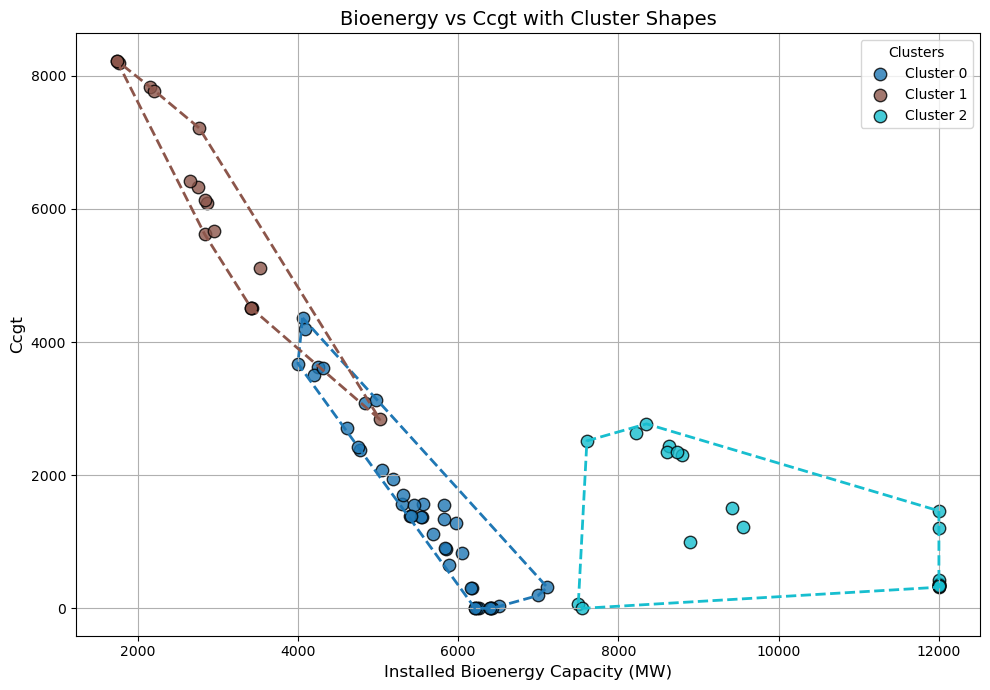

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['bioenergy'].values
y = aggregated_all['ccgt'].values
cluster_label = aggregated_all['Cluster_DBSCAN'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_label)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_label == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Bioenergy Capacity (MW)', fontsize=12)
plt.ylabel('Ccgt', fontsize=12)
plt.title('Bioenergy vs Ccgt with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

[2025-06-15 15:02:54] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_2300/3995766740.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))



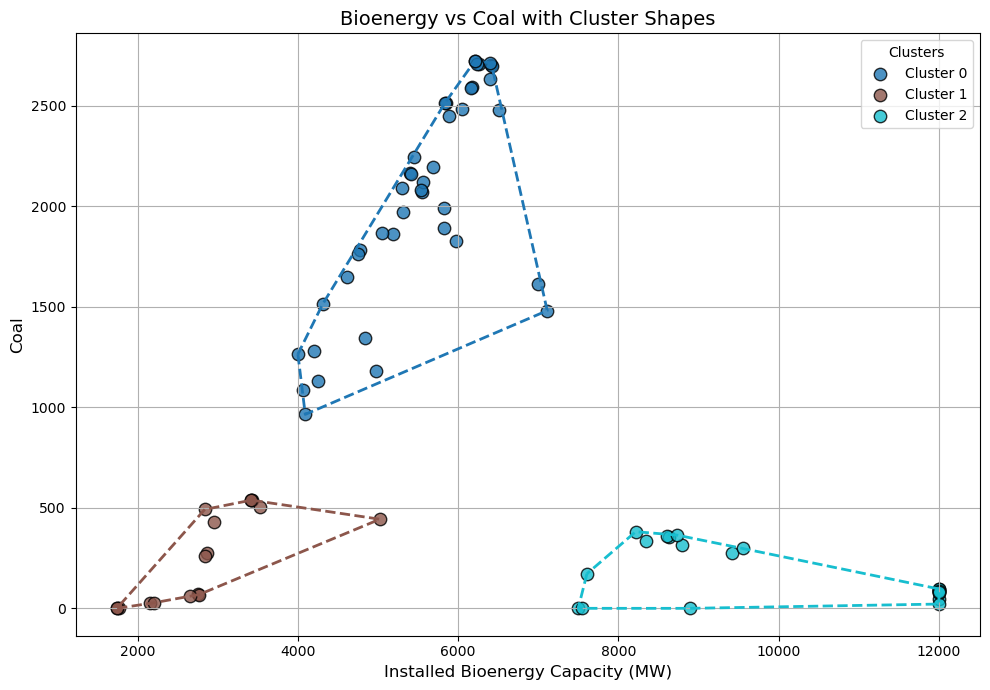

In [53]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull

# Extract x, y, and cluster labels
x = aggregated_all['bioenergy'].values
y = aggregated_all['coal'].values
cluster_label = aggregated_all['Cluster_DBSCAN'].values

# Unique clusters and colormap
unique_clusters = np.unique(cluster_label)
cmap = cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(10, 7))

# Plot each cluster individually
for i, cluster in enumerate(unique_clusters):
    mask = cluster_label == cluster
    x_cluster = x[mask]
    y_cluster = y[mask]

    # Plot cluster points
    plt.scatter(x_cluster, y_cluster,
                c=[cmap(i)], label=f'Cluster {cluster}',
                s=80, edgecolor='k', alpha=0.8)

    # Add convex hull if there are enough points
    if len(x_cluster) >= 3:
        points = np.column_stack((x_cluster, y_cluster))
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # close loop
        plt.plot(points[hull_points, 0], points[hull_points, 1],
                 linestyle='--', linewidth=2, color=cmap(i))

# Labels and legend
plt.xlabel('Installed Bioenergy Capacity (MW)', fontsize=12)
plt.ylabel('Coal', fontsize=12)
plt.title('Bioenergy vs Coal with Cluster Shapes', fontsize=14)
plt.grid(True)
plt.legend(title='Clusters', loc='best')
plt.tight_layout()
plt.show()

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

explained_variance = pca.explained_variance_ratio_
total_variance_explained = np.sum(explained_variance)

print(f"Explained variance by Component 1: {explained_variance[0]:.4f}")
print(f"Explained variance by Component 2: {explained_variance[1]:.4f}")
print(f"Total variance explained by the first 6 components: {total_variance_explained:.4f}")


Explained variance by Component 1: 0.2637
Explained variance by Component 2: 0.1518
Total variance explained by the first 6 components: 0.8978


In [58]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score

mask = cluster_labels != -1

db_score = davies_bouldin_score(X_pca[mask], cluster_labels[mask])
print(f"Davies-Bouldin score: {db_score:.3f}")
db_score_orig = davies_bouldin_score(matrix_scaled[mask], cluster_labels[mask])
print(f"DB score on original space: {db_score_orig:.3f}")

# Clusters from PCA-based clustering
ch_score_pca = calinski_harabasz_score(X_pca[mask], cluster_labels[mask])
print(f"CH score on PCA space: {ch_score_pca:.2f}")
ch_score_orig = calinski_harabasz_score(matrix_scaled[mask], cluster_labels[mask])
print(f"CH score on original space: {ch_score_orig:.2f}")

score = silhouette_score(X_pca[mask], cluster_labels[mask])
print(f'Silhouette score: {score:.3f}')
sh_score_orig = silhouette_score(matrix_scaled[mask], cluster_labels[mask])
print(f"SC score on original space: {sh_score_orig:.3f}")


Davies-Bouldin score: 0.477
DB score on original space: 0.550
CH score on PCA space: 177.44
CH score on original space: 141.21
Silhouette score: 0.638
SC score on original space: 0.597


Summarize the count of SPORE categories within each cluster by extracting general SPORE types and grouping by cluster and category.

In [59]:
metrics_summary = {
    'Davies-Bouldin': db_score_orig,
    'Calinski-Harabasz': ch_score_orig,
    'Silhouette': sh_score_orig
}
metrics_summary = pd.DataFrame({
    'score': ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'value': [sh_score_orig, db_score_orig, ch_score_orig]
})

In [60]:
# Dynamically extract the general SPORE category from the 'techs' index by splitting the names
aggregated_matrix_count = aggregated_matrix.copy()

aggregated_matrix_count['spore_category_general'] = aggregated_matrix_count.index.to_series().apply(lambda x: x.split('_spore')[0])

# Now, group by 'Cluster' and 'spore_category_general' and count the occurrences
cluster_spore_count = aggregated_matrix_count.groupby(['Cluster_DBSCAN', 'spore_category_general']).size().unstack(fill_value=0)

# Show the resulting table
cluster_spore_count['spore_main'] = cluster_spore_count[['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10']].sum(axis=1)
cluster_spore_count = cluster_spore_count.drop(columns=['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10'])

cluster_spore_count

spore_category_general,maxbat,maxbio,maxhtp,maxnuc,maxoff,maxons,maxpv,minbat,minbio,minhtp,minnuc,minoff,minons,minpv,spore_baseline,spore_main
Cluster_DBSCAN,,,,,,,,,,,,,,,,
-1,10,0,10,10,10,10,10,0,10,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,6,0,6,6,7,6,6,0,5
1,0,0,0,0,0,0,0,3,0,3,3,2,3,3,0,0
2,0,10,0,0,0,0,0,1,0,1,1,1,1,1,1,5


Remove noise points (outliers) from the aggregated matrix by excluding configurations labeled as noise by DBSCAN.

In [61]:
# remove the noise data points
aggregated_matrix = aggregated_matrix[aggregated_matrix['Cluster_DBSCAN'] != -1]

Calculate and display the mean technology capacities for each cluster.

In [62]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster_DBSCAN').mean()

# Show the resulting cluster summary
cluster_summary

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,nuclear,solar_pv,wind_offshore,wind_onshore
Cluster_DBSCAN,,,,,,,,,
0,1.703204,5547.700568,1485.016775,2042.844605,0.163379,492.583571,24359.001386,4755.384868,7024.195977
1,1.218898,2828.407058,6189.368501,251.253912,0.117692,489.798267,24359.002356,4755.834917,7744.645373
2,18.215317,10083.419763,1212.719300,164.411546,1.928843,534.505142,24359.183131,4754.854568,6955.071392


Plot a bar chart showing the average technology capacities for each cluster.

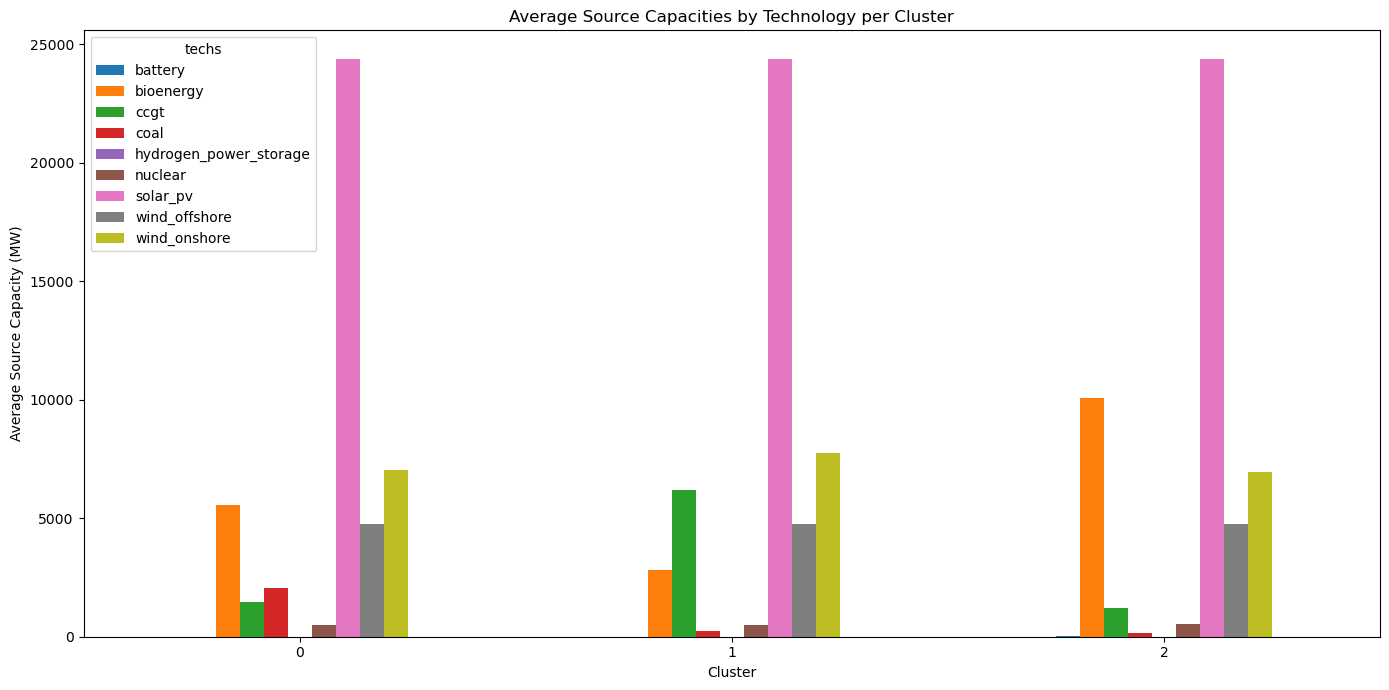

In [63]:
# Plot bar chart for each cluster
cluster_summary.plot(kind='bar', figsize=(14, 7))

plt.title('Average Source Capacities by Technology per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Source Capacity (MW)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Identify and plot the representative configuration (closest to centroid) for each cluster, showing technology capacities for each representative.

Cluster 0 - Shape of cluster_configs: (42, 9)
Cluster 1 - Shape of cluster_configs: (17, 9)
Cluster 2 - Shape of cluster_configs: (22, 9)
Representative configurations: ['minons_spore_8', 'minhtp_spore_6', 'spore_2']


<Figure size 1400x700 with 0 Axes>

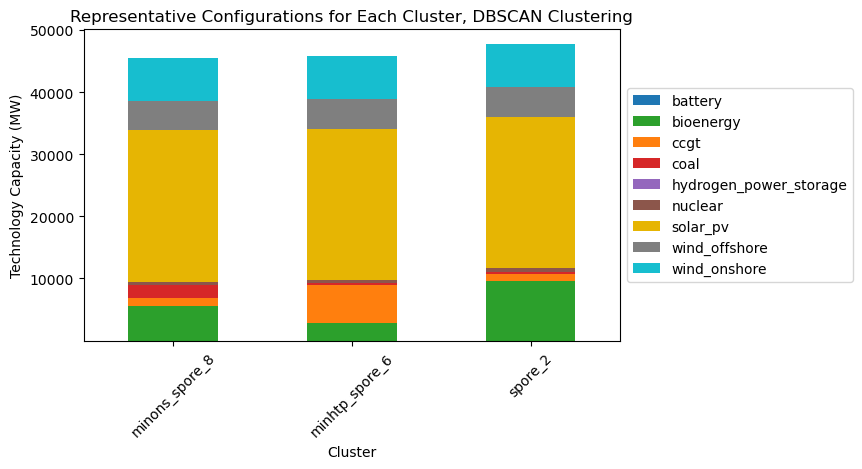

In [64]:
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np

# Assuming 'aggregated_matrix' is your DataFrame with the 'Cluster' and technology columns
# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster_DBSCAN').mean()


# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster_DBSCAN'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster_DBSCAN'] == cluster].drop(columns=['Cluster_DBSCAN'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs]

import seaborn as sns

colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd', '#8c564b',"#e6b503", '#7f7f7f', '#17becf']

# 4. Plot the representative configurations (one bar plot per cluster)
plt.figure(figsize=(14, 7))
df_representative_configs.drop(columns=['Cluster_DBSCAN']).plot(kind='bar', stacked=True, color=colors)

# Add titles and labels
plt.title('Representative Configurations for Each Cluster, DBSCAN Clustering')
plt.xlabel('Cluster')
plt.ylabel('Technology Capacity (MW)')
plt.xticks(range(len(df_representative_configs)), labels=representative_configs, rotation=45)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.show()

Extract systemwide levelized cost and capacity factor metrics for each SPORE from NetCDF files and organize them into a DataFrame indexed by SPORE and technology.

In [65]:
import glob
import xarray as xr
import pandas as pd

# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the performance metrics for each SPORE
performance_metrics_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Extract systemwide levelized cost (LCOE)
    data_sys_LCOE = data['systemwide_levelised_cost'].to_dataframe().reset_index()
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['costs'] == 'monetary']  # Filter for monetary costs
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['techs'] != 'lost_load']  # Exclude 'lost_load'
    data_sys_LCOE = data_sys_LCOE[~data_sys_LCOE['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_LCOE = data_sys_LCOE.drop(columns=['costs', 'carriers'])  # Drop unnecessary columns
    data_sys_LCOE = data_sys_LCOE[(data_sys_LCOE['techs'] != 'curtailment')&(data_sys_LCOE['techs'] != 'demand_power')&(data_sys_LCOE['techs'] != 'export_power')] # Exclude 'curtailment'
    
    # Extract systemwide capacity factor
    data_sys_cap = data['systemwide_capacity_factor'].to_dataframe().reset_index()
    data_sys_cap = data_sys_cap[~data_sys_cap['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_cap = data_sys_cap.drop(columns=['carriers'])  # Drop unnecessary columns
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'lost_load') & (data_sys_cap['techs'] != 'curtailment')]
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'demand_power') & (data_sys_cap['techs'] != 'export_power')]  # Exclude 'demand_power' and 'export_power'
    
    # Extract the SPORE name from the file name (e.g., 'maxnuc_spore_1')
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    
    # Merge the data for the current SPORE (levelized cost and capacity factor)
    performance_metrics_df = pd.DataFrame({
        'systemwide_levelized_cost': data_sys_LCOE.set_index('techs')['systemwide_levelised_cost'],
        'systemwide_capacity_factor': data_sys_cap.set_index('techs')['systemwide_capacity_factor']
    })
    
    # Add the 'techs' column back to the DataFrame for proper indexing
    performance_metrics_df['techs'] = performance_metrics_df.index
    
    # Add the SPORE name as a column for identification
    performance_metrics_df['spore_name'] = spore_name
    
    # Append the performance metrics for this SPORE to the list
    performance_metrics_list.append(performance_metrics_df)

# Combine all performance metrics data into a single DataFrame (with each SPORE as a row)
performance_metrics_matrix = pd.concat(performance_metrics_list, axis=0)

# Reorganize the matrix with 'techs' as the index and 'systemwide_levelized_cost' and 'systemwide_capacity_factor' as columns
performance_metrics_matrix = performance_metrics_matrix.set_index(['spore_name', 'techs'])

# Show the resulting performance metrics matrix
performance_metrics_matrix # Display the first few rows of the matrix for verification

systemwide_levelized_cost  \
spore_name     techs                                               
spore_5        battery                                  0.781309   
               bioenergy                                0.048679   
               ccgt                                     0.059055   
               coal                                     0.074788   
               hydrogen_power_storage                  18.345907   
...                                                          ...   
maxnuc_spore_4 import_power                             0.100000   
               nuclear                                  0.114333   
               solar_pv                                 0.064183   
               wind_offshore                            0.071631   
               wind_onshore                             0.054183   

                                       systemwide_capacity_factor  
spore_name     techs                                               
spore_5        battery                                   0.454780  
               bioenergy                                 0.999650  
               ccgt                                      0.997822  
               coal                                      0.999422  
               hydrogen_power_storage                    0.192320  
...                                                           ...  
maxnuc_spore_4 import_power                              0.052493  
               nuclear                                   0.999999  
               solar_pv                                  0.123826  
               wind_offshore                             0.299165  
               wind_onshore                              0.264519  

[1510 rows x 2 columns]

For each representative configuration, extract and display the systemwide levelized cost and capacity factor for all technologies.

In [66]:
# Initialize two lists to hold the levelized cost and capacity factor for each representative configuration
levelized_cost_list = []
capacity_factor_list = []

# Iterate over each representative configuration (row in df_representative_configs)
for config in df_representative_configs.index:
    spore_name = config  # SPORE name as 'techs' holds the SPORE name
    
    # Extract the systemwide levelized cost for each SPORE configuration
    levelized_cost = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_levelized_cost'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    capacity_factor = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_capacity_factor'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    
    # Append the results as rows in the respective lists
    levelized_cost_list.append(levelized_cost)
    capacity_factor_list.append(capacity_factor)

# Convert the lists into DataFrames
df_levelized_cost = pd.DataFrame(levelized_cost_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)
df_capacity_factor = pd.DataFrame(capacity_factor_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)

# Display the resulting DataFrames
print("Systemwide Levelized Cost Table:")
print(df_levelized_cost)
print("\nSystemwide Capacity Factor Table:")
print(df_capacity_factor)

Systemwide Levelized Cost Table:
techs            battery  bioenergy      ccgt      coal  \
minons_spore_8  0.785374   0.048710  0.059095  0.074959   
minhtp_spore_6  0.783690   0.050905  0.059040  0.074781   
spore_2         1.311944   0.049379  0.081249  0.102567   

techs           hydrogen_power_storage  import_power   nuclear  solar_pv  \
minons_spore_8               17.990836           0.1  0.114642  0.064183   
minhtp_spore_6               71.263391           0.1  0.114338  0.064183   
spore_2                      34.215501           0.1  0.123002  0.064183   

techs           wind_offshore  wind_onshore  
minons_spore_8       0.071664      0.054183  
minhtp_spore_6       0.071632      0.054183  
spore_2              0.071888      0.054185  

Systemwide Capacity Factor Table:
techs            battery  bioenergy      ccgt      coal  \
minons_spore_8  0.452413   0.998563  0.994332  0.995610   
minhtp_spore_6  0.453522   0.926809  0.999187  0.999579   
spore_2         0.455876   0.

Display the DataFrame of systemwide levelized costs for representative configurations.

<Figure size 1400x700 with 0 Axes>

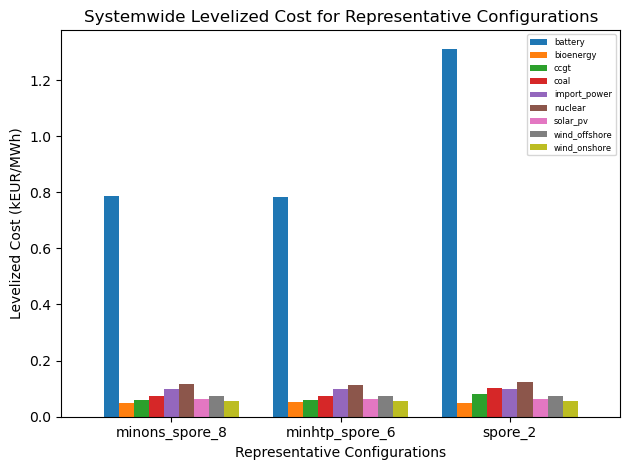

techs,battery,bioenergy,ccgt,coal,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
minons_spore_8,0.785374,0.048710,0.059095,0.074959,0.1,0.114642,0.064183,0.071664,0.054183
minhtp_spore_6,0.783690,0.050905,0.059040,0.074781,0.1,0.114338,0.064183,0.071632,0.054183
spore_2,1.311944,0.049379,0.081249,0.102567,0.1,0.123002,0.064183,0.071888,0.054185


In [67]:
plt.figure(figsize=(14, 7))
df_levelized_cost = df_levelized_cost.drop(columns=['hydrogen_power_storage'])
df_levelized_cost.plot(kind='bar', stacked=False, width=0.8)
plt.title('Systemwide Levelized Cost for Representative Configurations')
plt.xlabel('Representative Configurations')
plt.ylabel('Levelized Cost (kEUR/MWh)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(loc='upper right', prop={'size': 6})
plt.show()

df_levelized_cost

Display the DataFrame of systemwide capacity factors for representative configurations.

<Figure size 1400x700 with 0 Axes>

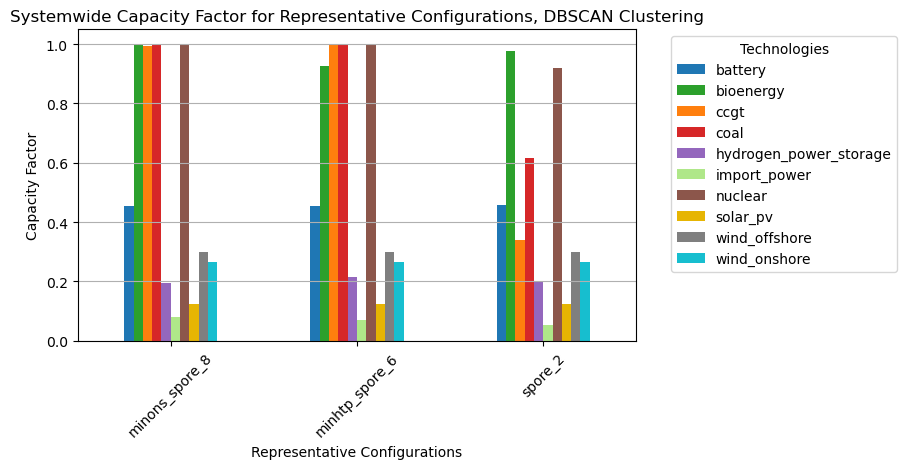

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
minons_spore_8,0.452413,0.998563,0.994332,0.995610,0.193936,0.078300,0.996928,0.123826,0.299026,0.264519
minhtp_spore_6,0.453522,0.926809,0.999187,0.999579,0.215883,0.070258,0.999949,0.123826,0.299162,0.264519
spore_2,0.455876,0.975555,0.338684,0.616381,0.196546,0.052216,0.920462,0.123826,0.298093,0.264512


In [68]:
plt.figure(figsize=(14, 7))
colors = ['#1f77b4','#2ca02c','#ff7f0e', '#d62728', '#9467bd', "#afe789", '#8c564b',"#e6b503", '#7f7f7f', '#17becf']
df_capacity_factor.plot(kind='bar', stacked=False, color=colors)
plt.title('Systemwide Capacity Factor for Representative Configurations, DBSCAN Clustering')
plt.xlabel('Representative Configurations')
plt.ylabel('Capacity Factor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Technologies', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

df_capacity_factor

In [69]:
with pd.ExcelWriter('results/output_DBSCAN_2.xlsx', engine='openpyxl') as writer:
    df_capacity_factor.to_excel(writer, sheet_name='systemwide_capacity_factor', index=False)
    df_levelized_cost.to_excel(writer, sheet_name='systemwide_levelized_cost', index=False)
    cluster_spore_count.to_excel(writer, sheet_name='spore_count', index=True)
    cluster_summary.to_excel(writer, sheet_name='cluster_summary', index=True)
    df_representative_configs.to_excel(writer, sheet_name='representative_configs', index=True)
    metrics_summary.to_excel(writer, sheet_name='metrics_summary', index=False)